In [1]:
from rsna_dataloader import *

In [2]:
data_basepath = "C://Users/Victor/Documents/python-doodles/data/rsna-2024-lumbar-spine-degenerative-classification/"

In [3]:
training_data = retrieve_training_data(data_basepath)

In [4]:
training_data.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,C://Users/Victor/Documents/python-doodles/data...
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,C://Users/Victor/Documents/python-doodles/data...
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,C://Users/Victor/Documents/python-doodles/data...
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,C://Users/Victor/Documents/python-doodles/data...
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,C://Users/Victor/Documents/python-doodles/data...


In [5]:
sample_image_paths = retrieve_image_paths(data_basepath + "train_images", 4003253, 702807833)

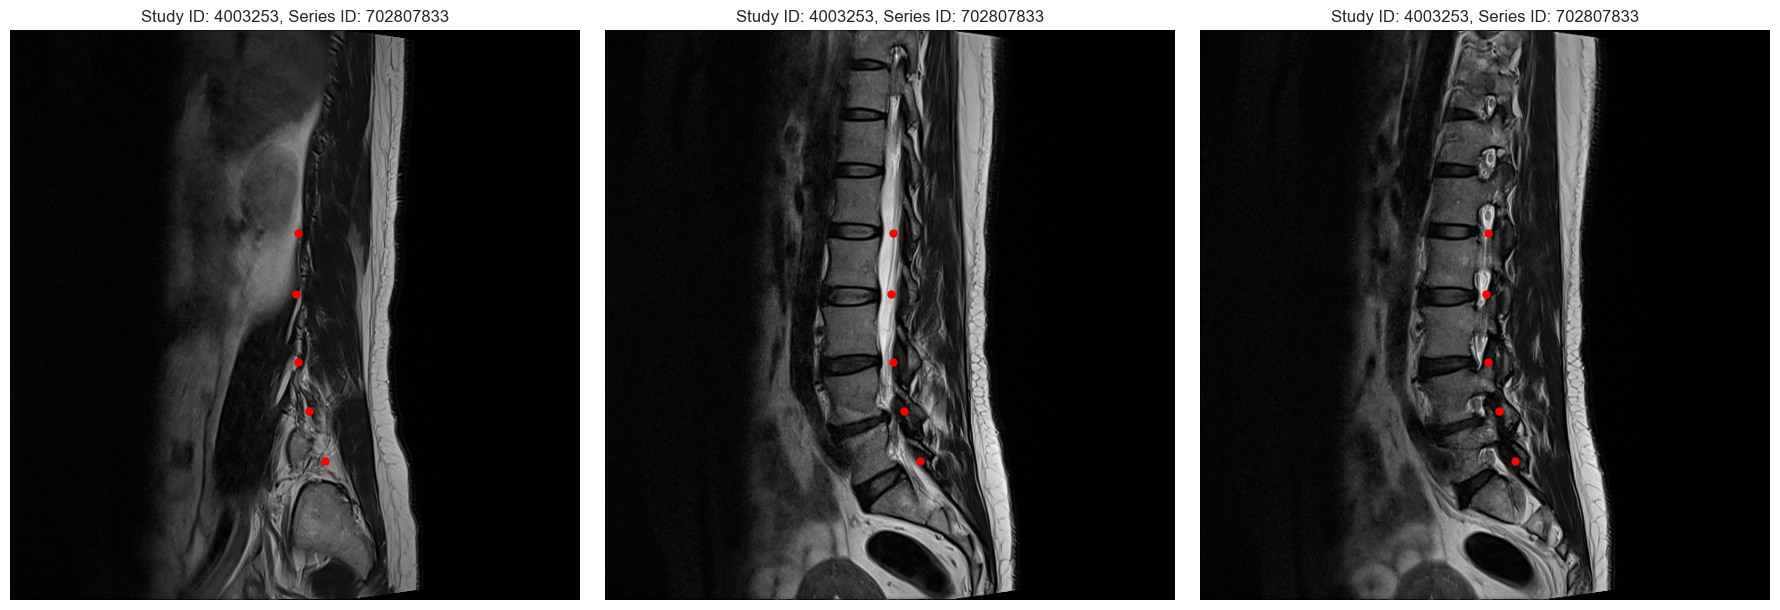

In [6]:
display_dicom_with_coordinates(sample_image_paths[0:3], training_data)

In [70]:
transform_train = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [71]:
trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_series_level_datasets_and_loaders(training_data, 'Sagittal T1', transform_train, transform_train, data_basepath + "train_images")
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_series_level_datasets_and_loaders(training_data, 'Axial T2', transform_train, transform_train, data_basepath + "train_images")
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_series_level_datasets_and_loaders(training_data, 'Sagittal T2/STIR', transform_train, transform_train, data_basepath + "train_images")

In [45]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [82]:
class CustomResNet(nn.Module):
    def __init__(self, pretrained_weights=None):
        super(CustomResNet, self).__init__()
        self.model = models.resnet50(pretrained=False)
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features=num_ftrs, out_features=512)

    def forward(self, x):
        return self.model(x)


class CustomLSTM(nn.Module):
    hidden_size = 256
    num_layers = 3
    
    def __init__(self, num_classes=3, resnet_weights=None):
        super(CustomLSTM, self).__init__()
        self.resnet = CustomResNet(pretrained_weights=resnet_weights)
        self.lstm = nn.LSTM(input_size=512, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.tail = nn.Sequential(
            nn.Linear(self.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x_3d):
        hidden = None
        
        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t])  
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(x.unsqueeze(0), hidden)         

        # Get the last hidden state (hidden is a tuple with both hidden and cell state in it)
        x = self.tail(hidden[0][-1])
       
        return x

In [83]:
def freeze_model_initial_layers(model: CustomLSTM):
    for param in model.resnet.model.parameters():
        param.requires_grad = False
    for param in model.resnet.model.fc.parameters():
        param.requires_grad = True

In [84]:
weights_path = '../models/resnet50-19c8e357.pth'

sagittal_t1_model = CustomLSTM(resnet_weights=weights_path).to(device)
axial_t2_model = CustomLSTM(resnet_weights=weights_path).to(device)
sagittal_t2stir_model = CustomLSTM(resnet_weights=weights_path).to(device)

optimizer_sagittal_t1 = torch.optim.Adam(sagittal_t1_model.parameters(), lr=0.001)
optimizer_axial_t2 = torch.optim.Adam(axial_t2_model.parameters(), lr=0.001)
optimizer_sagittal_t2stir = torch.optim.Adam(sagittal_t2stir_model.parameters(), lr=0.001)

C:\Users\Victor\anaconda3\envs\python-doodles\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Victor\anaconda3\envs\python-doodles\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [85]:
freeze_model_initial_layers(sagittal_t1_model)
freeze_model_initial_layers(axial_t2_model)
freeze_model_initial_layers(sagittal_t2stir_model)

In [86]:
trainable_params = sum(p.numel() for p in sagittal_t1_model.parameters() if p.requires_grad)
print(f"Number of parameters: {trainable_params}")

Number of parameters: 2923523


In [87]:
label_map = {'normal_mild': 0, 'moderate': 1, 'severe': 2}
print(len(trainloader_t1), len(trainloader_t2), len(trainloader_t2stir))

3692 4512 2725


In [88]:
def model_validation_loss(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0
    acc = 0
    for images, labels in val_loader:
        labels = torch.tensor([label_map[label] for label in labels])
        labels = labels.to(device)
        
        output = model(images.to(device))
        loss = loss_fn(output, labels)
        total_loss += loss.item()

        acc += torch.sum(torch.argmax(output) == labels)

    acc = acc / len(val_loader.dataset)

    return total_loss, acc

In [89]:
def train_model_with_validation(model, optimizer, loss_fn, train_loader, val_loader, train_loader_desc=None,
                                model_desc="my_model", epochs=10):
    epoch_losses = []
    epoch_validation_losses = []
    epoch_accs = []
    epoch_val_accs = []

    for epoch in tqdm(range(epochs), desc=train_loader_desc):
        epoch_loss = 0
        epoch_acc = 0
        model.train()

        for images, labels in train_loader:
            labels = torch.tensor([label_map[label] for label in labels])
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(images.to(device))
            loss = loss_fn(output, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

            epoch_acc += torch.sum(torch.argmax(output) == labels)

        epoch_acc = epoch_acc / len(train_loader.dataset)

        epoch_validation_loss, epoch_validation_acc = model_validation_loss(model, val_loader, loss_fn)

        if len(epoch_validation_losses) == 0 or epoch_validation_loss < min(epoch_validation_losses):
            torch.save(model, "C:/Users/Victor/Documents/python-doodles/models/" + model_desc + ".pt")

        epoch_validation_losses.append(epoch_validation_loss)
        epoch_losses.append(epoch_loss)
        epoch_accs.append(epoch_acc)
        epoch_val_accs.append(epoch_validation_acc)

    return epoch_losses, epoch_validation_losses, epoch_accs, epoch_val_accs


In [90]:
criterion = nn.CrossEntropyLoss()

In [91]:
losses_t1, val_losses_t1, acc_t1, val_acc_t1 = train_model_with_validation(sagittal_t1_model, optimizer_sagittal_t1, 
                                                                         criterion, trainloader_t1, valloader_t1, 
                                                                         model_desc="resnet50_t1", 
                                                                         train_loader_desc="Training Saggital T1", epochs=11)
plt.plot(losses_t1, label="train")
plt.plot(val_losses_t1, label="test")
plt.legend(loc="center right")
plt.show()

plt.plot([e.item() for e in acc_t1], label="train")
plt.plot([e.item() for e in val_acc_t1], label="val")
plt.legend(loc="center right")
plt.show()

Training Saggital T1:   0%|          | 0/11 [04:25<?, ?it/s]


KeyError: tensor(nan, dtype=torch.float64)